In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X_train = np.load('X_train.npy')
X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')

X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) )
X_valid = X_valid.reshape( (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) )
y_train = y_train.reshape( (-1, 1) )
y_valid = y_valid.reshape( (-1, 1) )
y_test = y_test.reshape( (-1, 1) )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(161825, 120, 25, 1) (161825, 1)
(5000, 120, 25, 1) (5000, 1)
(10000, 120, 25, 1) (10000, 1)


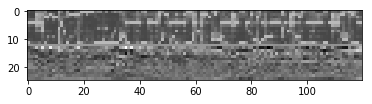

In [3]:
plt.imshow(X_train[2, :, :, 0].T, cmap='gray')

In [4]:
med = np.median(y_train)

def accuracy(pred, labels):
    return ( (pred > med) == (labels > med) ).mean()*100

In [48]:
batch_size = 128
time = 120
num_features = 25

#shape[0]==0 - max_pool
#shape[0]==1 - conv2d
#convs = [
#    [1, 1, 25, 1, 64],
#    [1, 1, 1, 64, 128],
#    [1, 3, 1, 128, 128],
#    [1, 3, 1, 128, 128],
#    [0, 1, 2, 1, 1],
#    [1, 3, 1, 128, 256],
#    [1, 3, 1, 256, 256],
#    [0, 1, 2, 1, 1],
#    [1, 3, 1, 256, 512],
#    [1, 3, 1, 512, 512],
#    [0, 1, 2, 1, 1],
#    [1, 3, 1, 512, 1024],
#    [1, 3, 1, 1024, 1024],
#    #[0, 1, 2, 1, 1],
#    [1, 3, 1, 1024, 1024],
#    [1, 3, 1, 1024, 1024]
#]
convs = [
    [1, 1, 25, 1, 32],
    [1, 1, 1, 32, 128],
    [1, 11, 1, 128, 128],
    [1, 5, 1, 128, 128],
    [1, 5, 1, 128, 64]
]

overall_size = 0

size = time, num_features
for s in convs:
    print(size)
    if s[0]==1:
        size = size[0] - s[1] + 1, size[1] - s[2] + 1
    else:
        size = size[0]//s[2], size[1]//s[3]
overall_size += size[0]*size[1]*convs[-1][-1]
print('size before dense layers:', overall_size)

dense = [
    [overall_size, 128],
    [128, 64],
    [64, 16],
    [16, 1]
]
dense_dropout = [1.0, 1.0, 1.0, 1.0]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  X_tr = tf.placeholder(
    tf.float32, shape=(batch_size, time, num_features, 1))
  y_tr = tf.placeholder(tf.float32, shape=(batch_size, 1))

  X_val = tf.constant(np.float32(X_valid))
    
  X_te = tf.constant(np.float32(X_test))

  # Variables.
  w_conv = []
  b_conv = []
  for s in convs:
    if s[0]==1:
        w_conv.append(tf.Variable(tf.truncated_normal(s[1:], stddev=0.05)))
        b_conv.append(tf.Variable(tf.zeros([s[-1]])))

  w_dense = []
  b_dense = []
  for s in dense:
    w_dense.append(tf.Variable(tf.truncated_normal(s, stddev=0.1)))
    b_dense.append(tf.Variable(tf.zeros(s[1])))
  
  # Model.
  def model(X):
    hidden = X
    j=0
    for i in range(len(convs)):
        if convs[i][0]==1:
            #print(hidden.get_shape(), w_conv[j].get_shape())
            hidden = tf.nn.conv2d(hidden, w_conv[j], [1, 1, 1, 1], padding='VALID')
            hidden = tf.nn.relu(hidden + b_conv[j])
            j += 1
        else:
            hidden = tf.nn.max_pool(hidden, convs[i][1:], convs[i][1:], padding='VALID')
    shape = hidden.get_shape().as_list()
    hidden = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #print( hidden.get_shape() , w_dense[0].get_shape())
    for i in range(len(w_dense)):
        hidden = tf.nn.xw_plus_b(hidden, w_dense[i], b_dense[i])
        if i < len(w_dense)-1:
            hidden = tf.nn.relu(hidden)
            hidden = tf.nn.dropout(hidden, dense_dropout[i])
    
    return hidden
  
  # Training computation.
  logits = model(X_tr)
  loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=y_tr, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.AdagradOptimizer(1e-3).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.sigmoid(logits)
  valid_prediction = tf.nn.sigmoid(model(X_val))
  test_prediction = tf.nn.sigmoid(model(X_te))

(120, 25)
(120, 1)
(120, 1)
(110, 1)
(106, 1)
size before dense layers: 6528


Initialized
Avg loss at step 0: 0.693304
Minibatch accuracy: 51.6%
Validation accuracy: 49.2%
Avg loss at step 100: 0.679450
Minibatch accuracy: 56.2%
Validation accuracy: 49.5%
Avg loss at step 200: 0.651173
Minibatch accuracy: 36.7%
Validation accuracy: 52.0%
Avg loss at step 300: 0.650022
Minibatch accuracy: 46.1%
Validation accuracy: 51.7%
Avg loss at step 400: 0.650928
Minibatch accuracy: 50.8%
Validation accuracy: 53.6%
Avg loss at step 500: 0.648901
Minibatch accuracy: 62.5%
Validation accuracy: 53.2%
Avg loss at step 600: 0.649538
Minibatch accuracy: 54.7%
Validation accuracy: 52.3%
Avg loss at step 700: 0.650009
Minibatch accuracy: 52.3%
Validation accuracy: 55.7%
Avg loss at step 800: 0.648288
Minibatch accuracy: 57.8%
Validation accuracy: 55.8%
Avg loss at step 900: 0.647829
Minibatch accuracy: 56.2%
Validation accuracy: 55.1%
Avg loss at step 1000: 0.648052
Minibatch accuracy: 55.5%
Validation accuracy: 57.1%
Avg loss at step 1100: 0.649848
Minibatch accuracy: 45.3%
Validat

Avg loss at step 9700: 0.643160
Minibatch accuracy: 60.9%
Validation accuracy: 57.9%
Avg loss at step 9800: 0.642243
Minibatch accuracy: 54.7%
Validation accuracy: 57.8%
Avg loss at step 9900: 0.645065
Minibatch accuracy: 58.6%
Validation accuracy: 57.8%
Avg loss at step 10000: 0.645831
Minibatch accuracy: 60.2%
Validation accuracy: 57.9%
Test accuracy: 58.3%


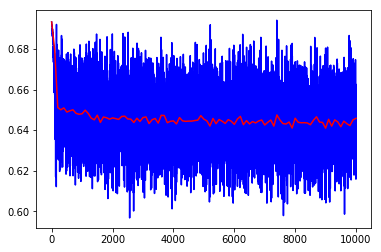

In [49]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  losses=[]
  avg=[]
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {X_tr : batch_data, y_tr : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    losses.append(l)
    if (step % 100 == 0):
      avg.append(sum(losses[-100:])/len(losses[-100:]))
      print('Avg loss at step %d: %f' % (step, avg[-1]))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), y_valid))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), y_test))
  plt.plot(range(num_steps), losses, 'b', np.array(range(len(avg)))*100, avg, 'r')
  plt.show()